# Modeling
Author: Griffin Brown

## Import Packages

In [281]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import os
from io import StringIO
from prophet import Prophet
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from itertools import islice

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

plt.style.use('ggplot')

In [282]:
df = pd.read_csv('IWC_Work_Orders_Extract.csv')

In [283]:
dfpl = pl.read_csv('IWC_Work_Orders_Extract.csv')

In [284]:
%%time
df['ORDER_ID'].count()

CPU times: user 752 μs, sys: 517 μs, total: 1.27 ms
Wall time: 841 μs


np.int64(1427264)

In [285]:
%%time
dfpl['ORDER_ID'].count()

CPU times: user 19 μs, sys: 74 μs, total: 93 μs
Wall time: 95.1 μs


1427264

Experimenting with polars, dataset isn't really big enough to justify.

In [286]:
df.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO
0,705642457,G812,ROMA,2024-05-04,2024-05-12,06:00:00.000,23:04:08.000,390.0,NaN,NaN,Unplanned,L2 GEARBOX LEAK (SEE ATTACHED),Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
1,704191697,G812,ROMA,2022-09-13,2022-09-13,06:00:00.000,17:17:24.000,420.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR AT CAN CODER,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
2,704466547,G812,ROMA,2022-12-21,2022-12-21,07:00:00.000,07:00:00.000,30.0,NaN,NaN,Unplanned,BROKEN CONVEYOR RAIL,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
3,703834477,G812,ROMA,2022-07-04,2022-07-04,06:00:00.000,06:00:00.000,60.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,9999-12-31
4,704661125,G291,MONZA,2023-03-15,2023-03-15,07:00:00.000,07:00:00.000,120.0,NaN,NaN,Unplanned,REPLACED SONIC AIR BLOWER BELT,Corrective Maintenance Order,G291-PRD-P05,MONZA PRODUCTION,AIR SYSTEMS,NaN,NaN,NaN,300001088.0,TANK_STL_STOR_AIR,Machines,2017-02-15,2023-12-11,9999-12-31


In [287]:
# change valid date columns to datetime
dates = ['EXECUTION_START_DATE', 'EXECUTION_FINISH_DATE', 'EQUIP_START_UP_DATE', 'EQUIP_VALID_FROM', 'EQUIP_VALID_TO']

for col in dates:
    df[col] = pd.to_datetime(df[col], errors='coerce')

In [288]:
df['EQUIPMENT_ID'] = df['EQUIPMENT_ID'].fillna(1)
df = df[df['EXECUTION_START_DATE'] >= '2018-01-01']

## Silverstone Example

In [289]:
df_sil = df[df['PRODUCTION_LOCATION']=='SILVERSTONE']

In [290]:
df_sil.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO
6042,901724580,G261,SILVERSTONE,2023-03-01,2023-03-01,12:52:00.000,12:52:00.000,0.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT
6043,207731527,G261,SILVERSTONE,2022-12-14,2022-12-14,13:04:00.000,17:30:00.000,100.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT
6045,200003228916,G261,SILVERSTONE,2022-08-05,2022-08-05,19:06:00.000,21:40:00.000,153.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT
6046,200000808319,G261,SILVERSTONE,2018-05-16,2018-05-16,18:11:00.000,19:01:00.000,50.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT
6053,401519840,G261,SILVERSTONE,2021-07-23,2021-07-23,13:01:00.000,16:50:00.000,422.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT


In [291]:
len(df_sil['EQUIPMENT_ID'].unique())

603

In [292]:
df_sil.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO
6042,901724580,G261,SILVERSTONE,2023-03-01,2023-03-01,12:52:00.000,12:52:00.000,0.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT
6043,207731527,G261,SILVERSTONE,2022-12-14,2022-12-14,13:04:00.000,17:30:00.000,100.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT
6045,200003228916,G261,SILVERSTONE,2022-08-05,2022-08-05,19:06:00.000,21:40:00.000,153.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT
6046,200000808319,G261,SILVERSTONE,2018-05-16,2018-05-16,18:11:00.000,19:01:00.000,50.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT
6053,401519840,G261,SILVERSTONE,2021-07-23,2021-07-23,13:01:00.000,16:50:00.000,422.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT


In [293]:
mean_times = df_sil.groupby('EQUIPMENT_ID').agg(
    mean_times = ('ACTUAL_WORK_IN_MINUTES', 'mean')
)


In [294]:
mean_times.sort_values(by='mean_times')

,mean_times
EQUIPMENT_ID,
300017263.0,0.000000
300017352.0,1.200000
300019302.0,1.200000
300017390.0,1.200000
400002800.0,6.000000
...,...
300019029.0,435.000000
300017222.0,480.000000
300019225.0,480.000000


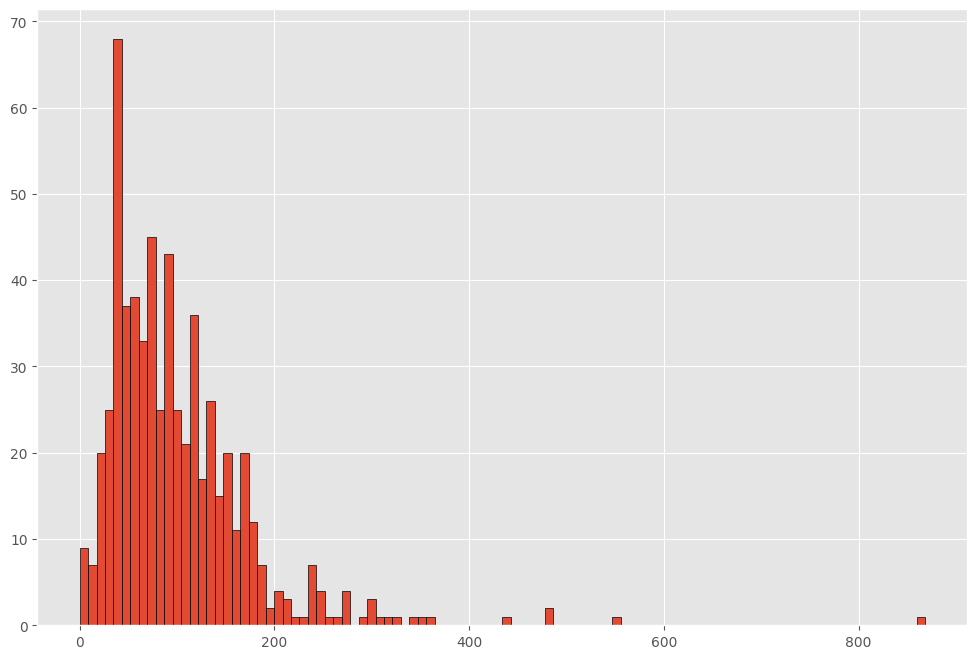

In [295]:
plt.figure(figsize=(12,8))
plt.hist(mean_times, bins=100, edgecolor='black')
plt.show()

In [296]:
time_bins=[0, 100, 250, 400, 1000]
labels=['Low', 'Medium', 'High', 'Critical']
mean_times['bin'] = pd.cut(mean_times['mean_times'], bins=time_bins, labels=labels)

When moving to a production model, the bins will have to be generalized. This is also only considering how long a typical job takes, not how often or cumulative spend of time.

In [297]:
mean_times.head()

,mean_times,bin
EQUIPMENT_ID,,
1.0,91.346381,Low
300017213.0,118.500000,Medium
300017214.0,127.125424,Medium
300017215.0,62.892857,Low
300017217.0,93.736364,Low


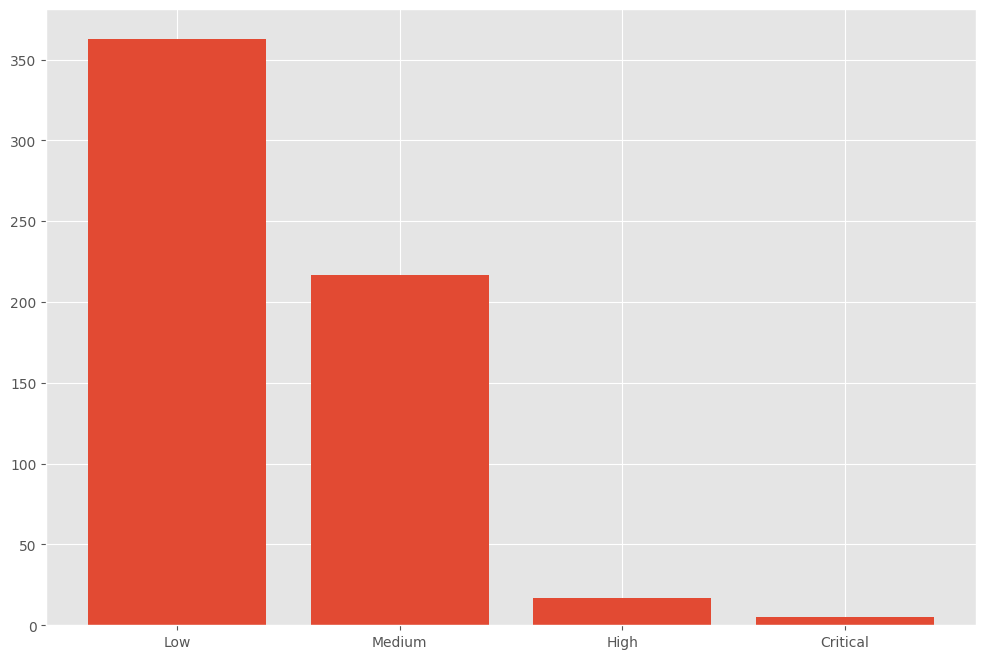

In [298]:
plt.figure(figsize=(12,8))
bin_counts = mean_times.groupby('bin').size()
plt.bar(bin_counts.index, bin_counts.values)
plt.show()

In [299]:
df_sil = pd.merge(df_sil, mean_times, on=('EQUIPMENT_ID'), how='left')

In [300]:
df_sil.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO,mean_times,bin
0,901724580,G261,SILVERSTONE,2023-03-01,2023-03-01,12:52:00.000,12:52:00.000,0.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT,91.346381,Low
1,207731527,G261,SILVERSTONE,2022-12-14,2022-12-14,13:04:00.000,17:30:00.000,100.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT,91.346381,Low
2,200003228916,G261,SILVERSTONE,2022-08-05,2022-08-05,19:06:00.000,21:40:00.000,153.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT,91.346381,Low
3,200000808319,G261,SILVERSTONE,2018-05-16,2018-05-16,18:11:00.000,19:01:00.000,50.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT,91.346381,Low
4,401519840,G261,SILVERSTONE,2021-07-23,2021-07-23,13:01:00.000,16:50:00.000,422.0,NaN,NaN,Unplanned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaT,NaT,NaT,91.346381,Low


In [301]:
df_sil_low = df_sil[(df_sil['bin']=='Low') & (df_sil['EXECUTION_START_DATE'] > '2016-10-01')].filter(['EXECUTION_START_DATE'])

In [302]:
df_sil_low

,EXECUTION_START_DATE
0,2023-03-01
1,2022-12-14
2,2022-08-05
3,2018-05-16
4,2021-07-23
...,...
550421,2022-01-24
550422,2020-10-23
550423,2022-04-10
550424,2022-08-18


In [303]:
count_orders_low = df_sil_low.groupby('EXECUTION_START_DATE').agg(
    counts = ('EXECUTION_START_DATE', 'size')
).sort_values(by='EXECUTION_START_DATE')

count_orders_low.head()

,counts
EXECUTION_START_DATE,
2018-01-01,38
2018-01-02,195
2018-01-03,253
2018-01-04,265
2018-01-05,230


### Prophet

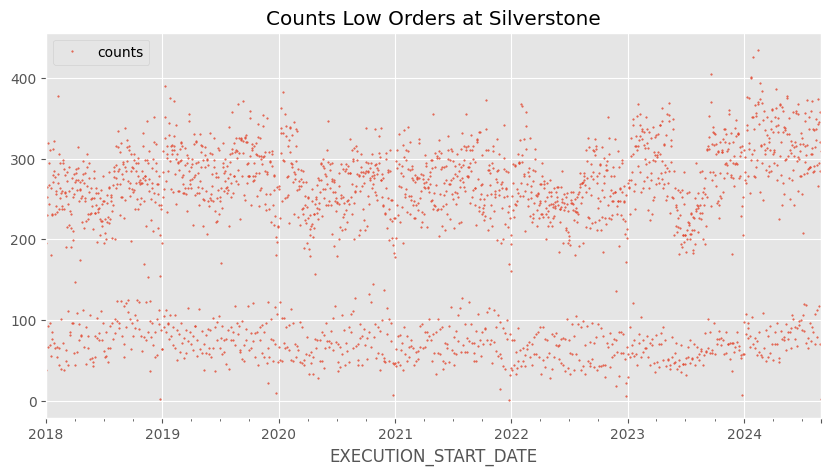

In [304]:
color_pal = sns.color_palette()
count_orders_low.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='Counts Low Orders at Silverstone')
plt.show()

### Create Features

In [305]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(count_orders_low, label='counts')
features_and_target = pd.concat([X, y], axis=1)

### Distributions

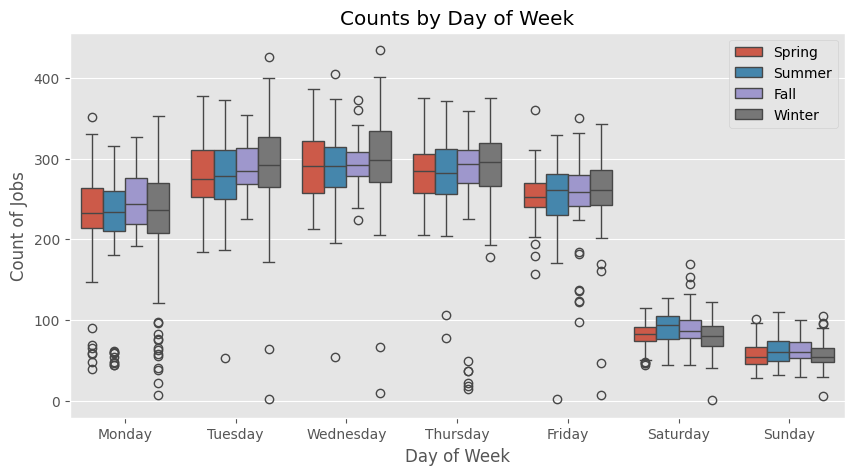

In [306]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='counts',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Counts by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Count of Jobs')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

### Split Visual

In [307]:
count_orders_low.index.max()

Timestamp('2024-08-30 00:00:00')

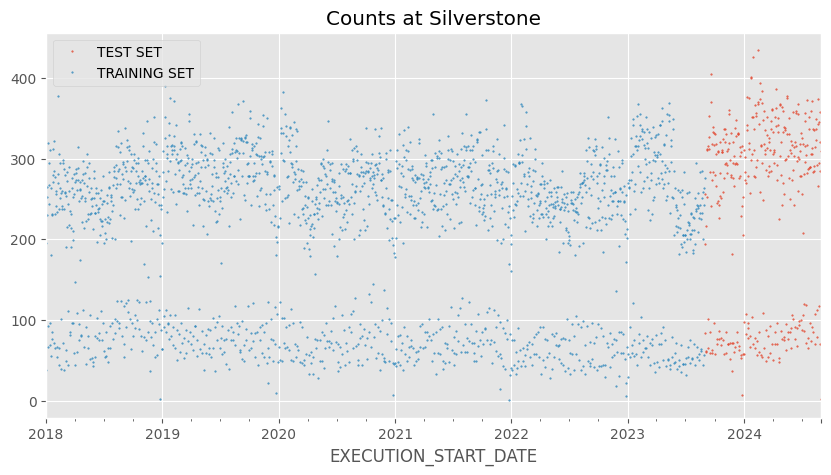

In [308]:
split_date = '2023-08-30'
count_orders_low_train = count_orders_low.loc[count_orders_low.index <= split_date].copy()
count_orders_low_test = count_orders_low.loc[count_orders_low.index > split_date].copy()

# Plot train and test so you can see where we have split
count_orders_low_test \
    .rename(columns={'counts': 'TEST SET'}) \
    .join(count_orders_low_train.rename(columns={'counts': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Counts at Silverstone', style='.', ms=1)
plt.show()

### Model

In [309]:
counts_train_prophet = count_orders_low_train.reset_index() \
    .rename(columns={'EXECUTION_START_DATE':'ds',
                     'counts':'y'})



In [310]:
%%time
model = Prophet()
model.fit(counts_train_prophet)

17:14:50 - cmdstanpy - INFO - Chain [1] start processing
17:14:50 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 47.1 ms, sys: 11.3 ms, total: 58.4 ms
Wall time: 151 ms


In [311]:
# Predict on test set with model
count_orders_low_test_prophet = count_orders_low_test.reset_index() \
    .rename(columns={'EXECUTION_START_DATE':'ds',
                     'counts':'y'})

count_orders_low_test_fcst = model.predict(count_orders_low_test_prophet)

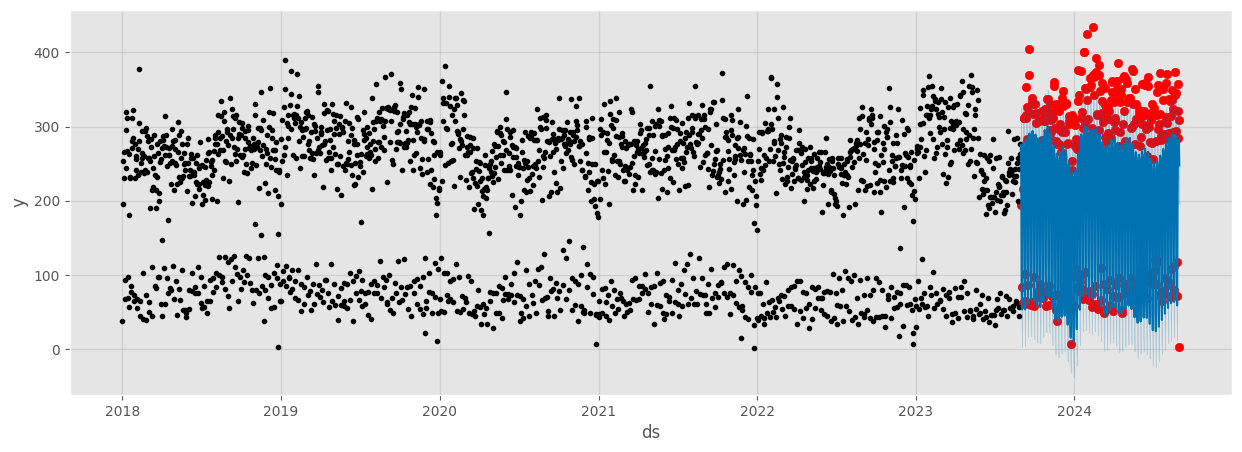

In [312]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(count_orders_low_test.index, count_orders_low_test['counts'], color='r')
fig = model.plot(count_orders_low_test_fcst, ax=ax)

In [313]:
mape_sil_low = mean_absolute_percentage_error(y_true=count_orders_low_test['counts'],
                               y_pred=count_orders_low_test_fcst['yhat'])

print(f'MAPE: {mape_sil_low:.4f}')

MAPE: 0.6379


## Pipeline

### Create Dataframes Based on Location

In [314]:
df_roma = df[df['PRODUCTION_LOCATION']=='ROMA']
df_monza = df[df['PRODUCTION_LOCATION']=='MONZA']
df_cota = df[df['PRODUCTION_LOCATION']=='COTA']
df_monaco = df[df['PRODUCTION_LOCATION']=='MONACO']
df_suzuka = df[df['PRODUCTION_LOCATION']=='SUZUKA']
df_silverstone = df[df['PRODUCTION_LOCATION']=='SILVERSTONE']


### Create Aggregates

In [315]:
def aggregate_dataframe(df):
    df_aggs = df.groupby('EQUIPMENT_ID').agg(
        average_time = ('ACTUAL_WORK_IN_MINUTES', 'mean')
        #count_orders = ('ORDER_ID', 'size'),
        #sum_mins = ('ACTUAL_WORK_IN_MINUTES', 'sum')
    )

    return df_aggs

In [316]:
df_roma_aggs = aggregate_dataframe(df_roma)

In [317]:
df_roma_aggs.head()

,average_time
EQUIPMENT_ID,
1.0,13.337498
200108112.0,102.000000
200108117.0,100.000000
200108119.0,67.500000
200108120.0,112.500000


In [318]:
df_roma_aggs.sort_values('average_time', ascending=False)

,average_time
EQUIPMENT_ID,
300126855.0,2040.000000
300127032.0,664.200000
300017689.0,540.000000
300017626.0,498.000000
300126873.0,481.200000
...,...
1.0,13.337498
300126814.0,9.000000
300017669.0,9.000000


In [319]:
def normalize_aggs(df):
    # Extract the relevant columns
    df_values = df[['average_time']]

    # Initialize the scaler
    scaler = MinMaxScaler()

    # Normalize the columns
    normalized_values = scaler.fit_transform(df_values)
    df[['norm_average_time']] = normalized_values

    return df

In [320]:
df_roma_norm = normalize_aggs(df_roma_aggs)

df_roma_norm.head()

,average_time,norm_average_time
EQUIPMENT_ID,,
1.0,13.337498,0.003901
200108112.0,102.000000,0.047479
200108117.0,100.000000,0.046496
200108119.0,67.500000,0.030522
200108120.0,112.500000,0.052639


## Experimental Prophet

### Binning (to be continued)

Can binning into a certain level of need work?

In [321]:
# Calculate the average work time for each EQUIPMENT_ID and assign it back to the DataFrame
df_roma['average_time'] = df_roma.groupby('EQUIPMENT_ID')['ACTUAL_WORK_IN_MINUTES'].transform('mean')


In [322]:
time_bins=[0, 100, 250, 400, 1000]
labels=['Low', 'Medium', 'High', 'Critical']
df_roma['bin'] = pd.cut(df_roma['average_time'], bins=time_bins, labels=labels)

df_roma.head()

,ORDER_ID,PLANT_ID,PRODUCTION_LOCATION,EXECUTION_START_DATE,EXECUTION_FINISH_DATE,ACTUAL_START_TIME,ACTUAL_FINISH_TIME,ACTUAL_WORK_IN_MINUTES,MAINTENANCE_PLAN,MAINTENANCE_ITEM,MAINTENANCE_ACTIVITY_TYPE,ORDER_DESCRIPTION,MAINTENANCE_TYPE_DESCRIPTION,FUNCTIONAL_LOC,FUNCTIONAL_AREA_NODE_1_MODIFIED,FUNCTIONAL_AREA_NODE_2_MODIFIED,FUNCTIONAL_AREA_NODE_3_MODIFIED,FUNCTIONAL_AREA_NODE_4_MODIFIED,FUNCTIONAL_AREA_NODE_5_MODIFIED,EQUIPMENT_ID,EQUIPMENT_DESC,EQUIP_CAT_DESC,EQUIP_START_UP_DATE,EQUIP_VALID_FROM,EQUIP_VALID_TO,average_time,bin
0,705642457,G812,ROMA,2024-05-04,2024-05-12,06:00:00.000,23:04:08.000,390.0,NaN,NaN,Unplanned,L2 GEARBOX LEAK (SEE ATTACHED),Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,225.000000,Medium
1,704191697,G812,ROMA,2022-09-13,2022-09-13,06:00:00.000,17:17:24.000,420.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR AT CAN CODER,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,225.000000,Medium
2,704466547,G812,ROMA,2022-12-21,2022-12-21,07:00:00.000,07:00:00.000,30.0,NaN,NaN,Unplanned,BROKEN CONVEYOR RAIL,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,225.000000,Medium
3,703834477,G812,ROMA,2022-07-04,2022-07-04,06:00:00.000,06:00:00.000,60.0,NaN,NaN,Unplanned,LINE 3 CONVEYOR,Corrective Maintenance Order,G812-PRD-L15-L03-L030-020,PRODUCTION,G812 PRD FILLER_ROTARY_CAN,G812 PRD FILLER_ROTARY_CAN LINE 3,CONVEYOR,FULL CAN CONVEYOR,300126812.0,FULL CAN CONVEYOR (FC41B),Machines,2020-04-22,2020-02-10,NaT,225.000000,Medium
108,705115969,G812,ROMA,2023-09-26,2023-09-26,06:00:00.000,12:30:02.000,480.0,NaN,NaN,Unplanned,ROGERS AIR COMPRESSOR,Corrective Maintenance Order,G812-PRD-P05-XXX,PRODUCTION,G812 AIR SYSTEMS,G812 AIR SYSTEMS,NaN,NaN,300129004.0,ROGERS AIR COMPRESSOR (COMP #1),Machines,2020-04-22,2020-02-18,NaT,91.066667,Low


### Prophet by Equipment

#### Fit

In [323]:
df_roma_aggregated = df.groupby(['EXECUTION_START_DATE', 'EQUIPMENT_ID']).size().reset_index(name='work_order_count')

df_roma_aggregated

,EXECUTION_START_DATE,EQUIPMENT_ID,work_order_count
0,2018-01-01,1.0,83
1,2018-01-01,300001023.0,1
2,2018-01-01,300001025.0,1
3,2018-01-01,300001078.0,3
4,2018-01-01,300001079.0,1
...,...,...,...
206108,2024-08-29,300272207.0,3
206109,2024-08-29,300272408.0,1
206110,2024-08-29,300273599.0,1
206111,2024-08-29,400028800.0,1


In [324]:
filtered_df_roma_aggregated = df_roma_aggregated.groupby('EQUIPMENT_ID').filter(lambda x: x['work_order_count'].notna().sum() >= 2)

# Extract unique equipment IDs from the filtered DataFrame
equipment_ids = filtered_df_roma_aggregated['EQUIPMENT_ID'].unique()

# Initialize and fit Prophet models only for the filtered equipment IDs
models = {}

In [326]:
for equipment_id in islice(equipment_ids, 0, 10):
    # Filter data for each equipment
    equipment_data = filtered_df_roma_aggregated[filtered_df_roma_aggregated['EQUIPMENT_ID'] == equipment_id]
    equipment_data = equipment_data.rename(columns={'EXECUTION_START_DATE': 'ds', 
                                                    'work_order_count': 'y'
                                                    })
    
    # Initialize and fit Prophet model
    model = Prophet()
    model.fit(equipment_data)
    
    # Store the model
    models[equipment_id] = model

17:15:38 - cmdstanpy - INFO - Chain [1] start processing
17:15:38 - cmdstanpy - INFO - Chain [1] done processing
17:15:38 - cmdstanpy - INFO - Chain [1] start processing
17:15:38 - cmdstanpy - INFO - Chain [1] done processing
17:15:38 - cmdstanpy - INFO - Chain [1] start processing
17:15:38 - cmdstanpy - INFO - Chain [1] done processing
17:15:38 - cmdstanpy - INFO - Chain [1] start processing
17:15:38 - cmdstanpy - INFO - Chain [1] done processing
17:15:38 - cmdstanpy - INFO - Chain [1] start processing
17:15:39 - cmdstanpy - INFO - Chain [1] done processing
17:15:39 - cmdstanpy - INFO - Chain [1] start processing
17:15:39 - cmdstanpy - INFO - Chain [1] done processing
17:15:39 - cmdstanpy - INFO - Chain [1] start processing
17:15:39 - cmdstanpy - INFO - Chain [1] done processing
17:15:39 - cmdstanpy - INFO - Chain [1] start processing
17:15:39 - cmdstanpy - INFO - Chain [1] done processing
17:15:39 - cmdstanpy - INFO - Chain [1] start processing
17:15:39 - cmdstanpy - INFO - Chain [1]

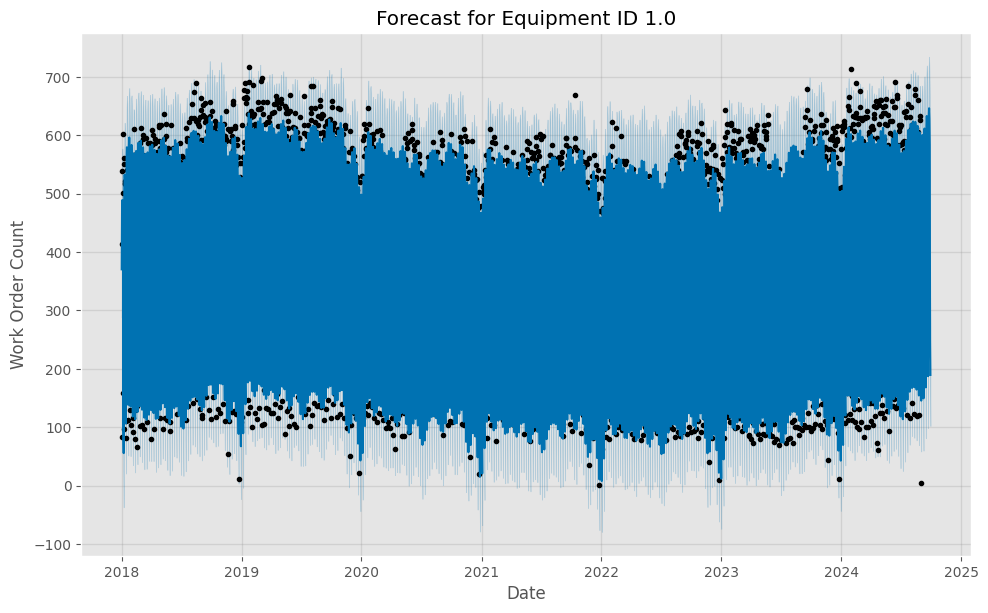

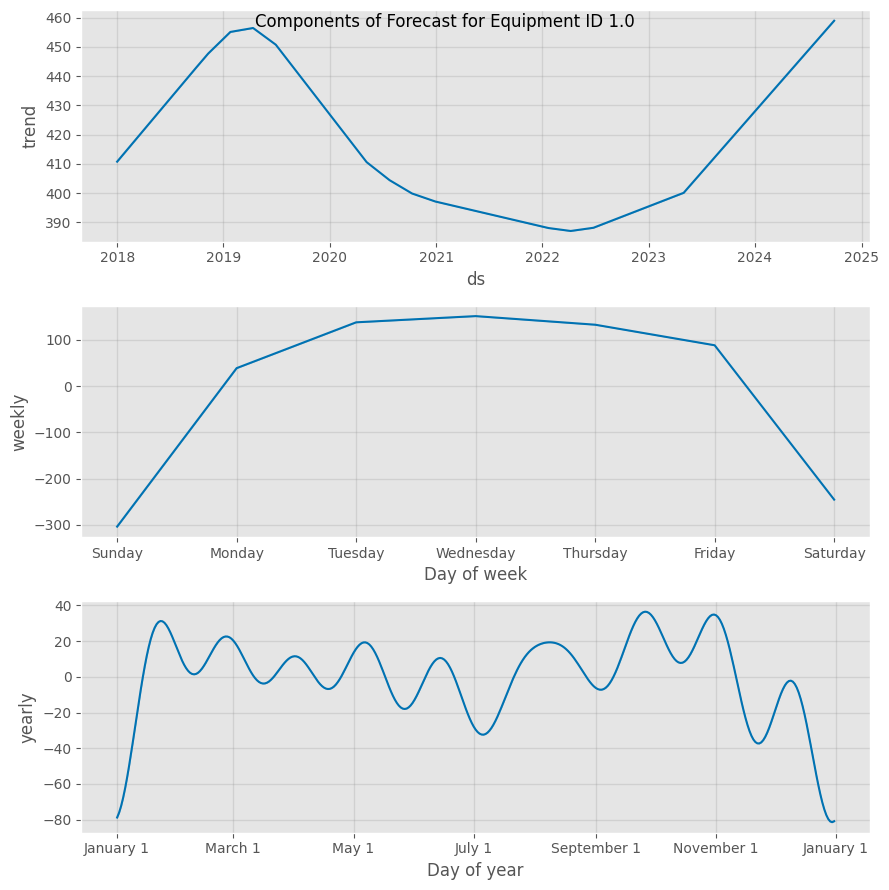

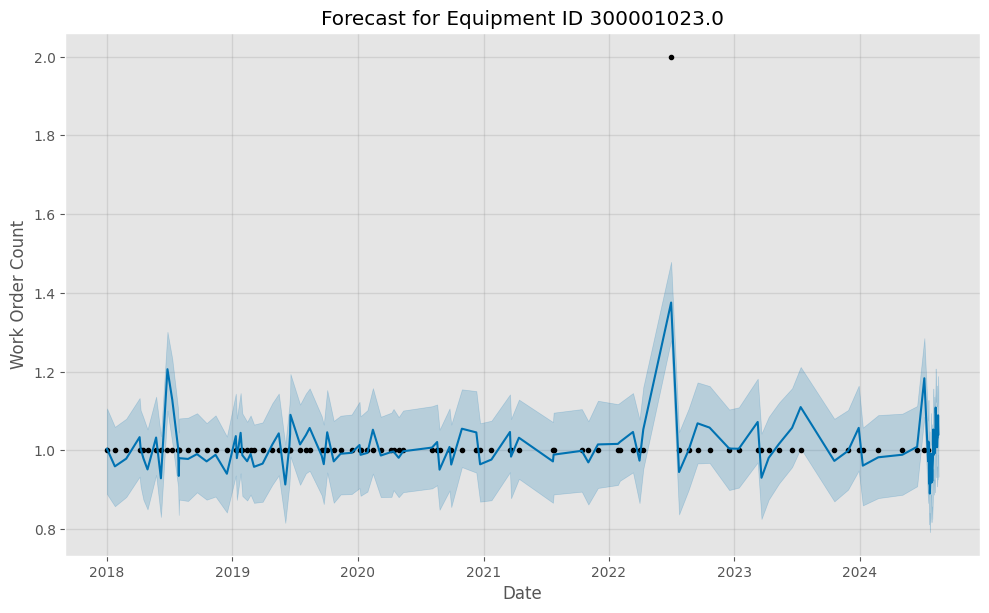

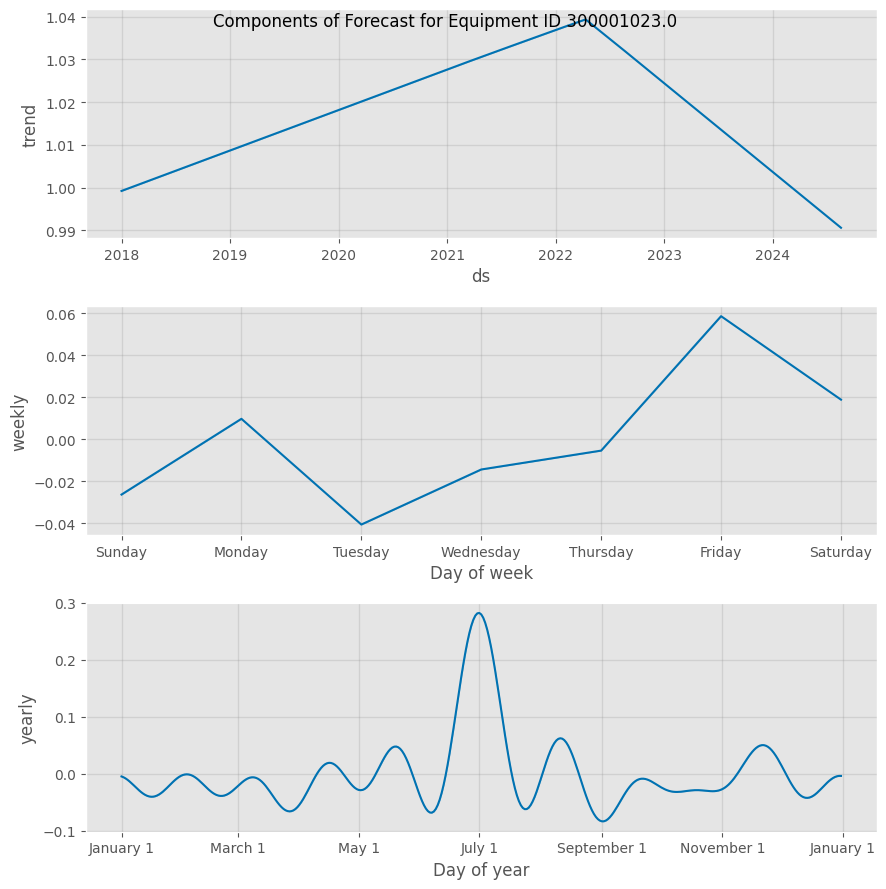

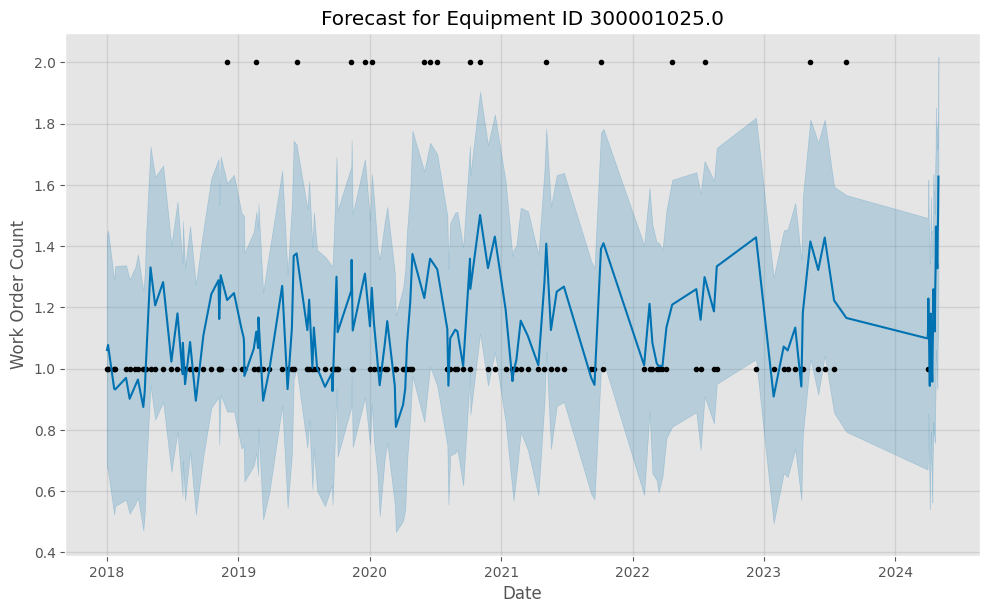

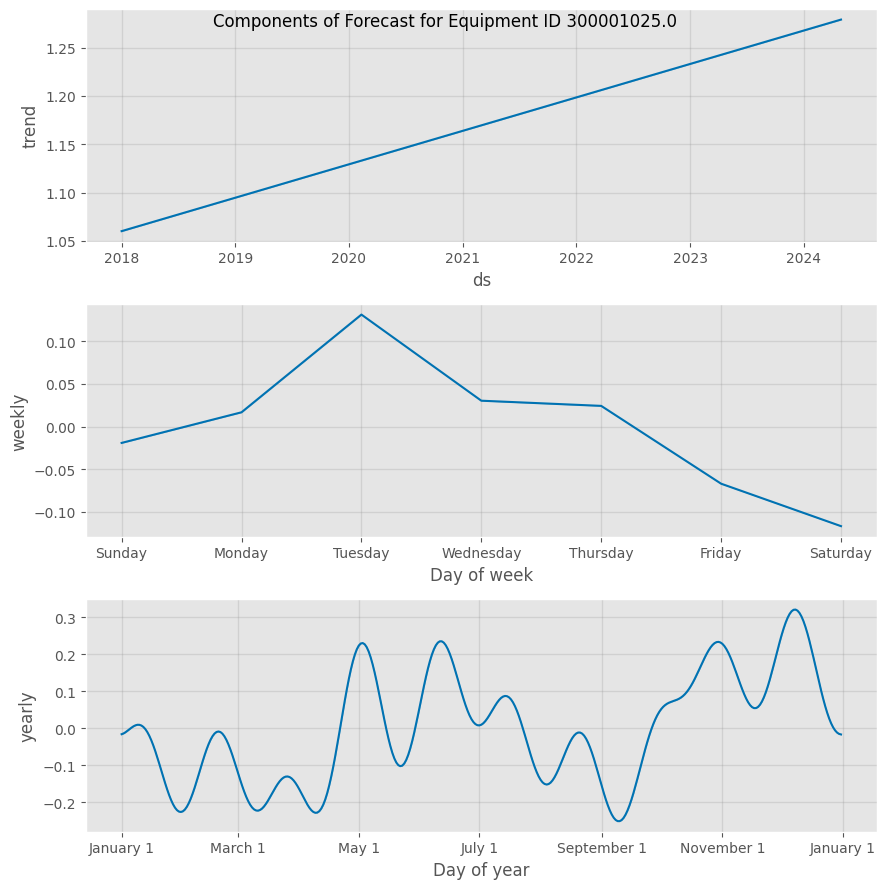

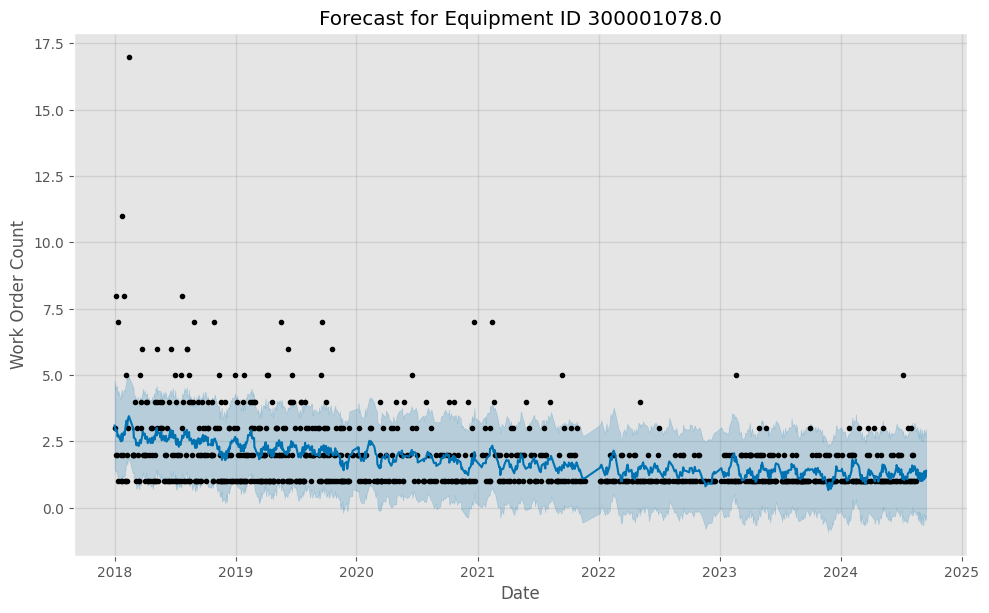

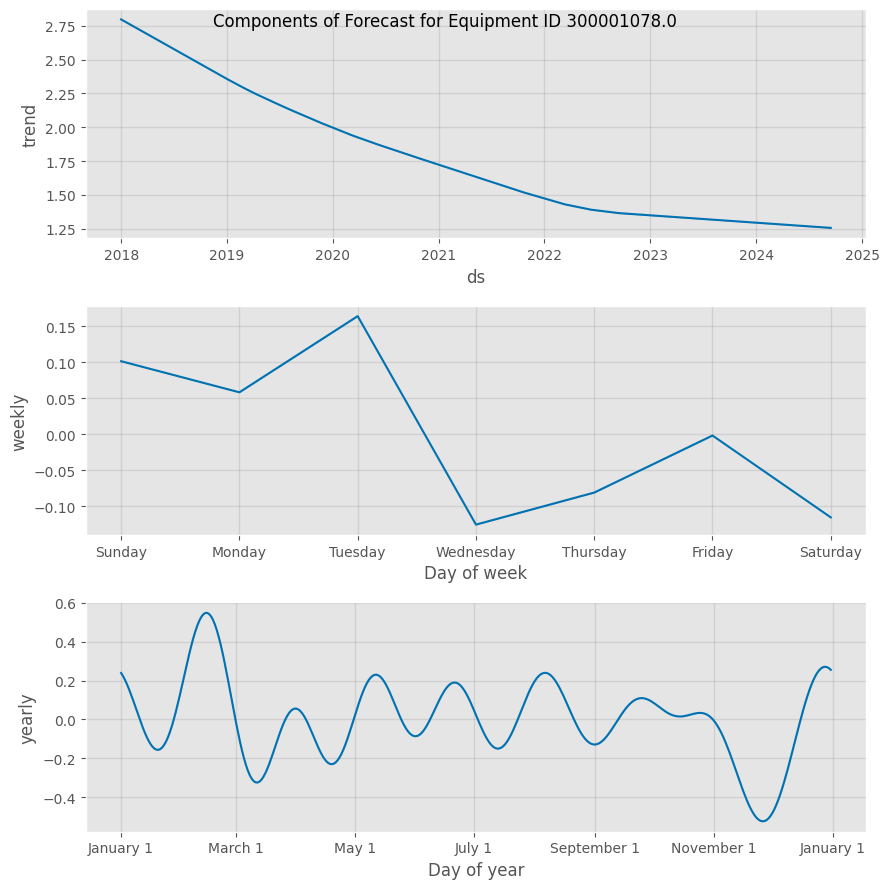

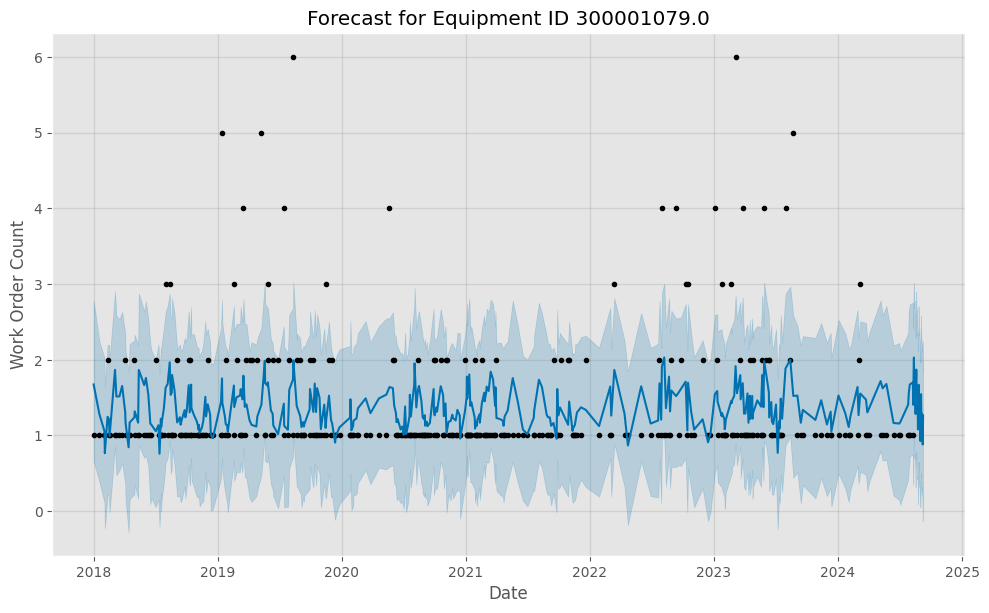

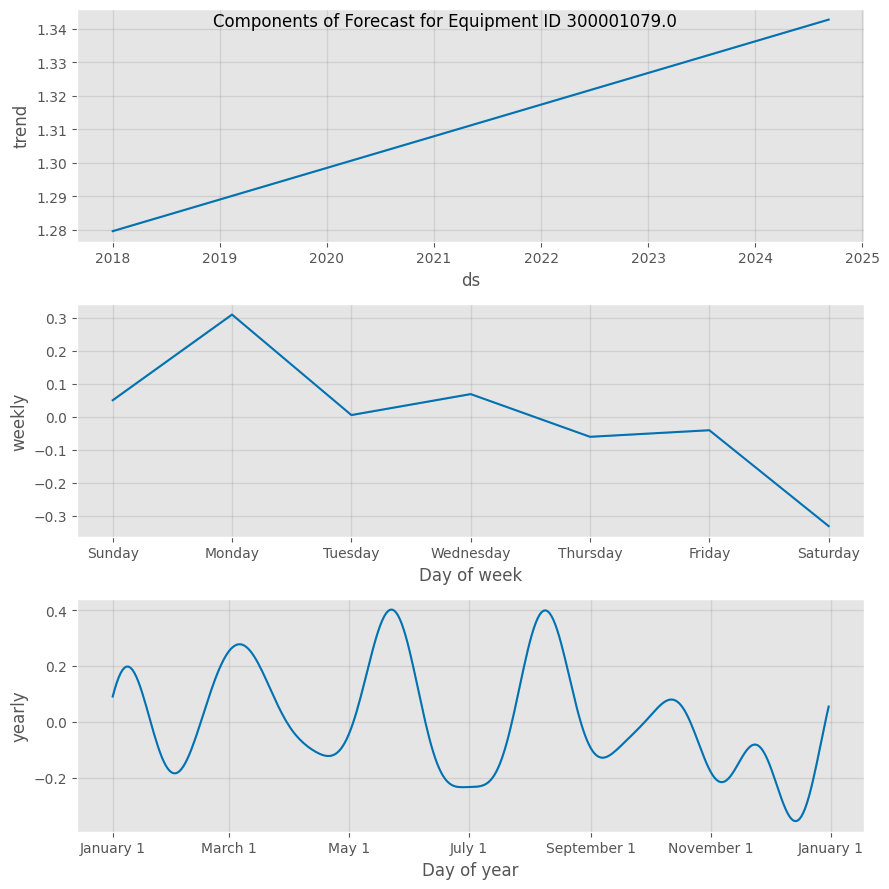

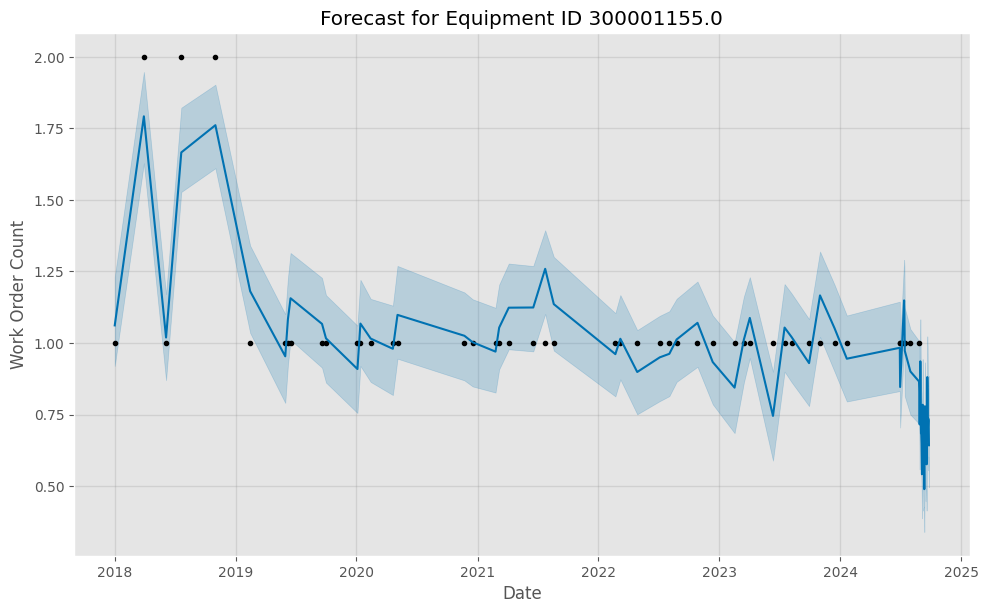

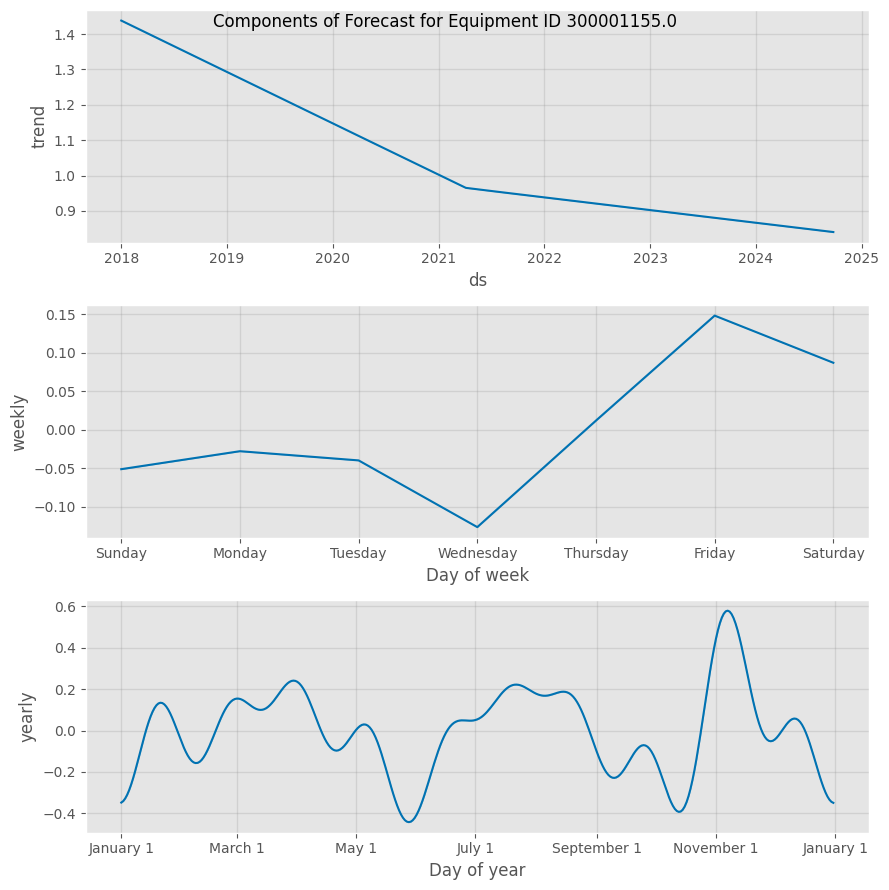

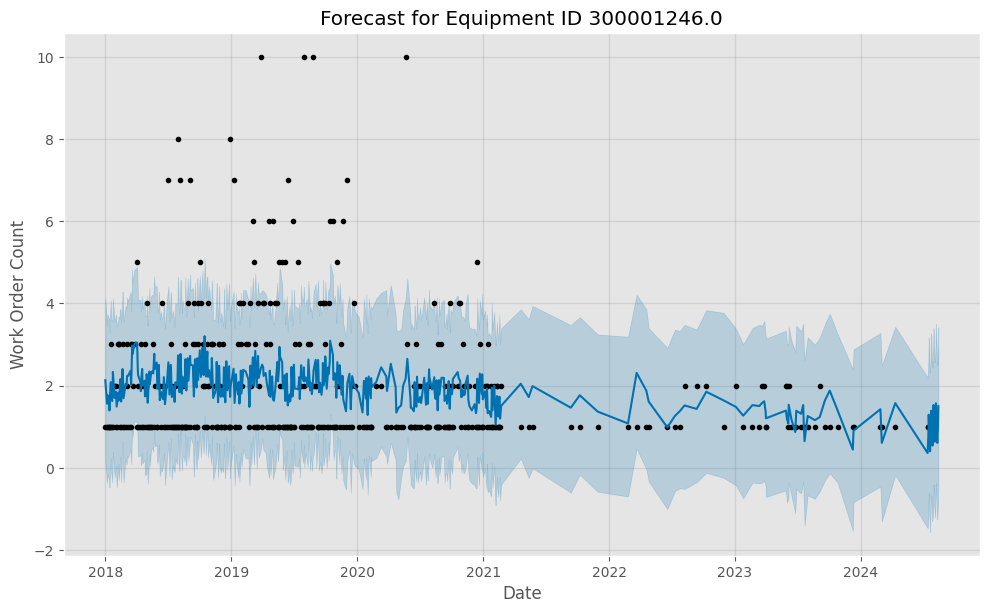

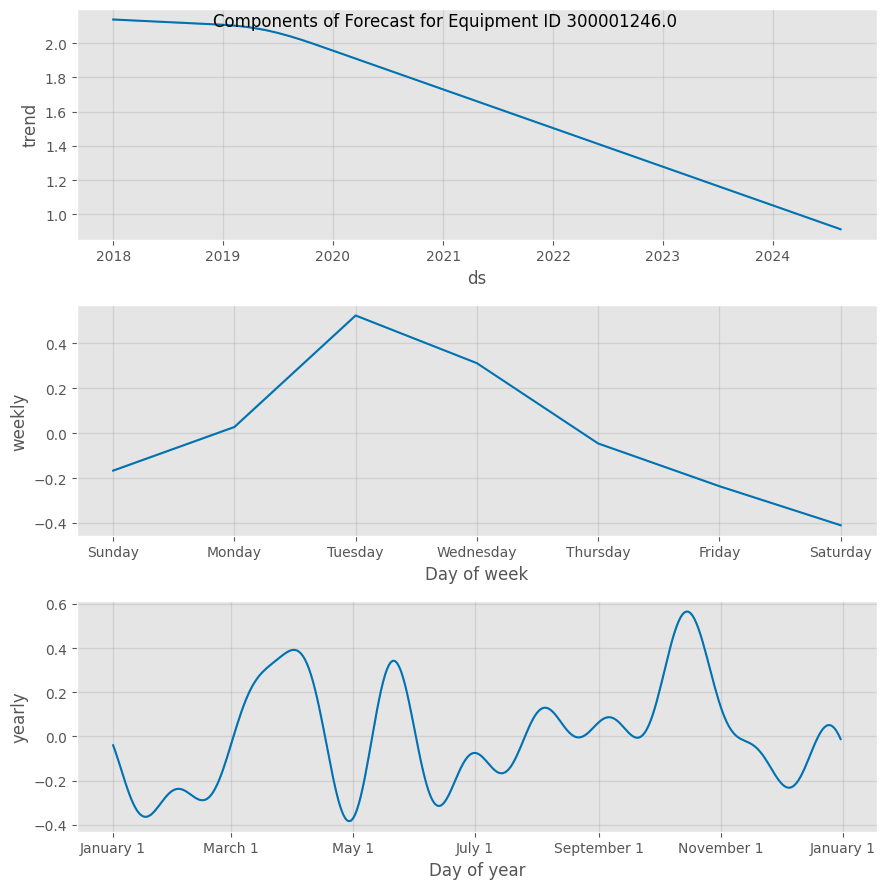

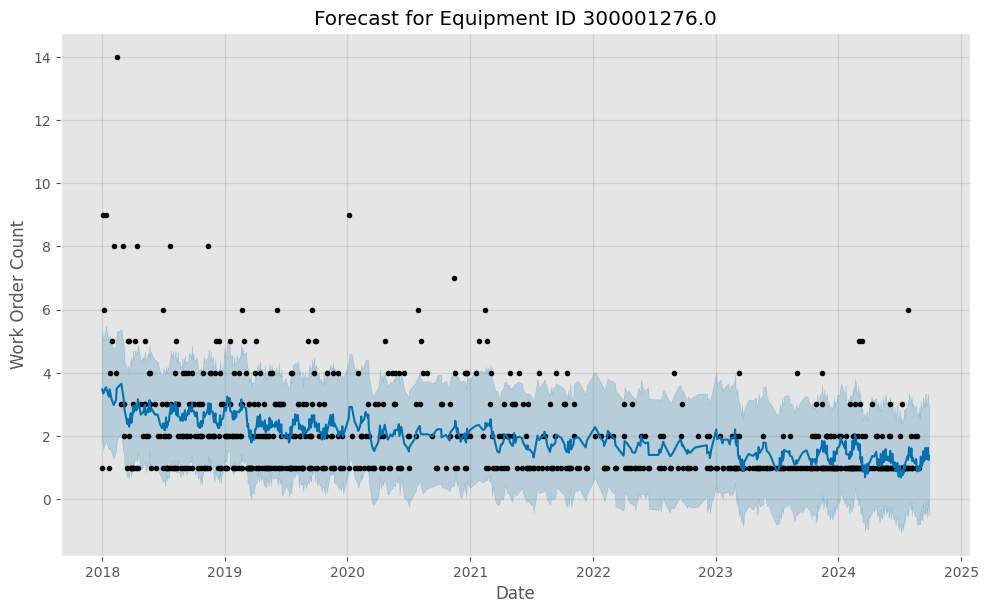

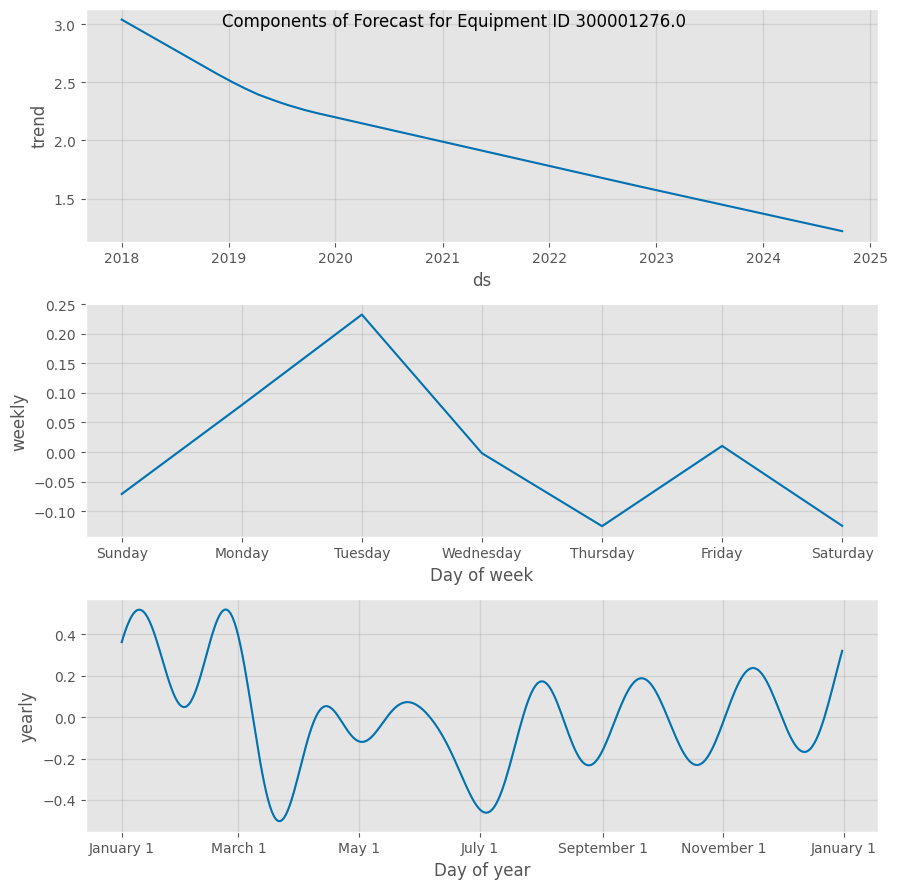

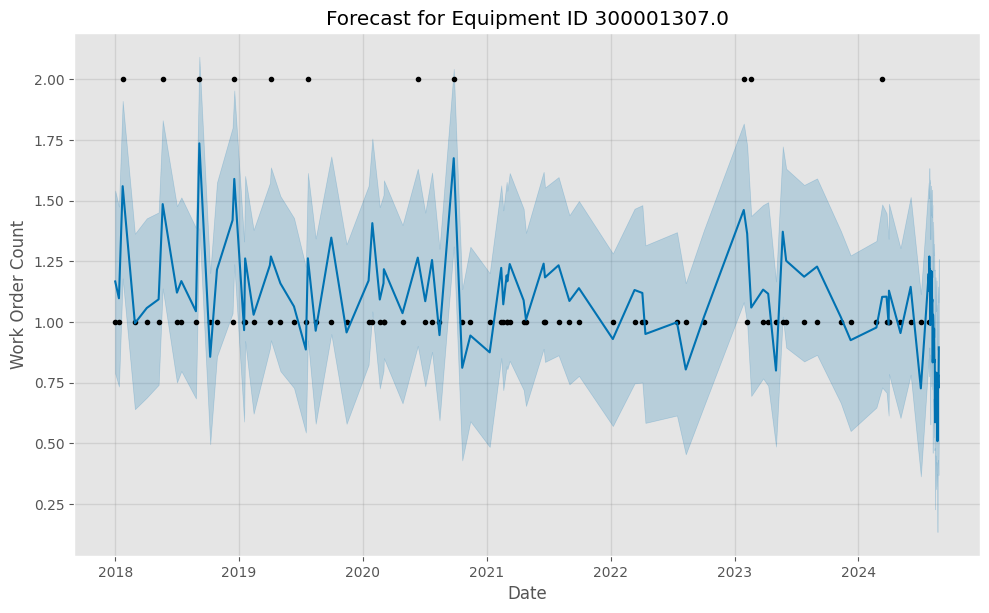

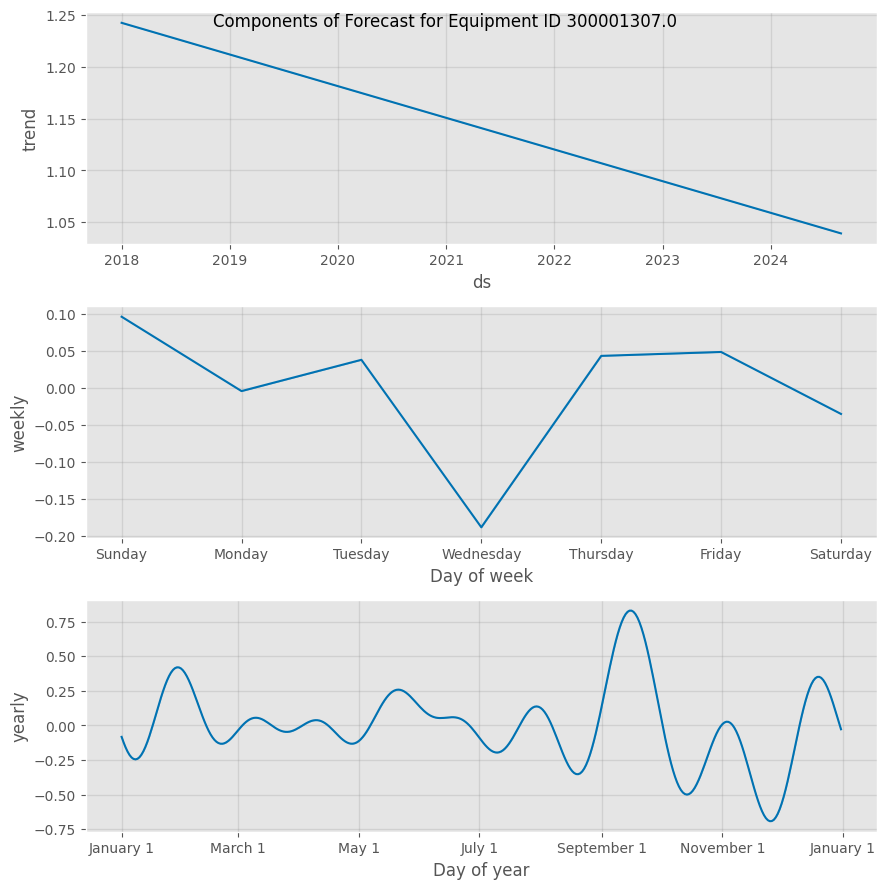

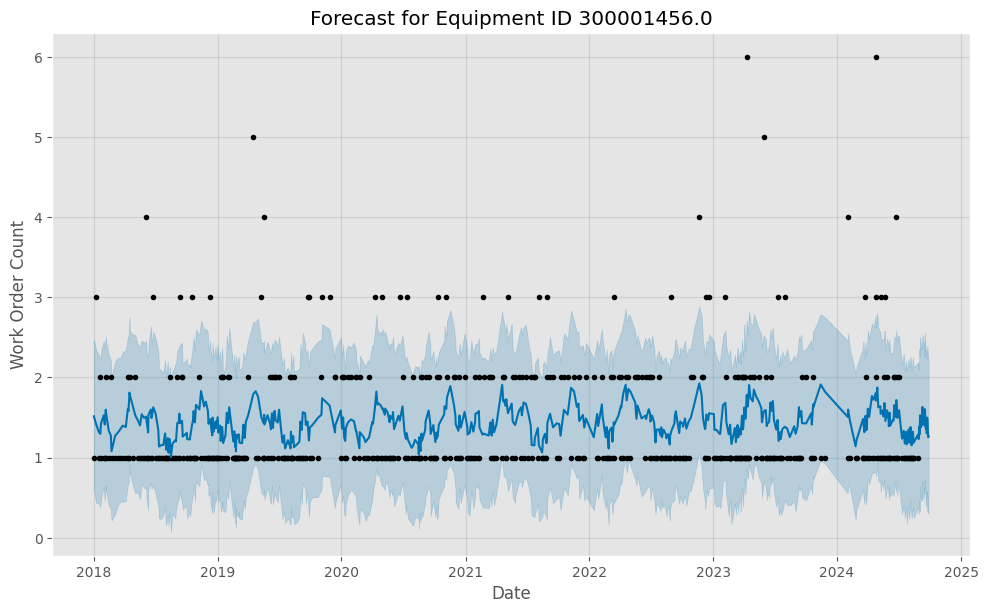

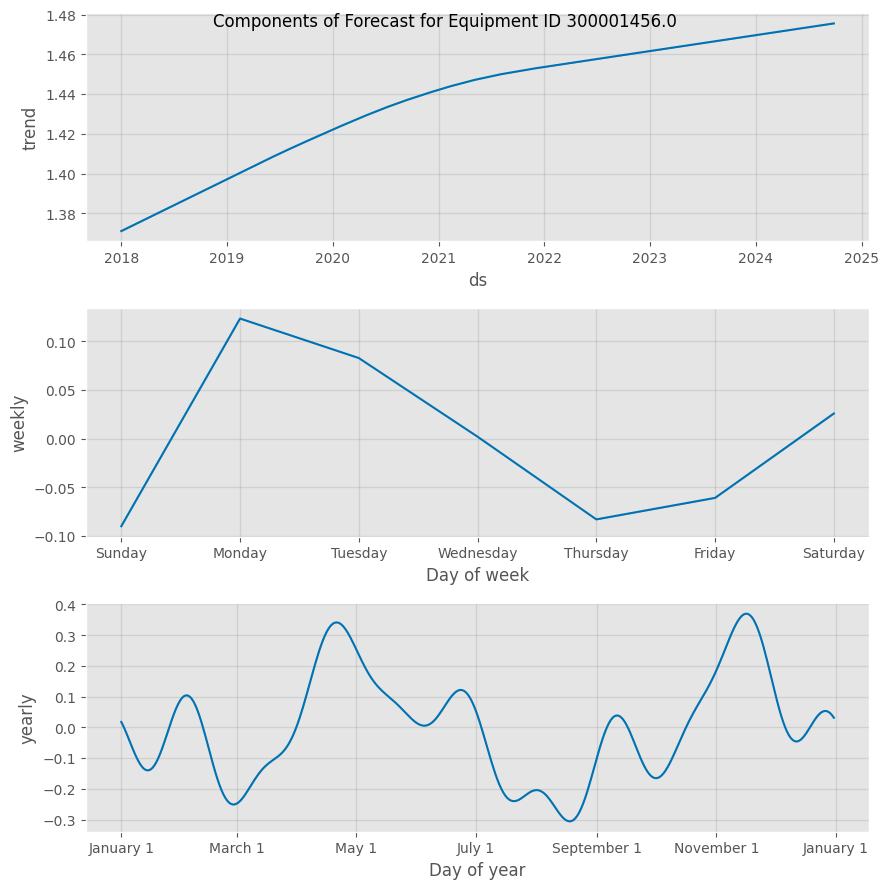

In [327]:
forecast_period = 30

# Loop through each model and visualize the forecast
for equipment_id, model in islice(models.items(), 0, 10):
    # Create a future DataFrame for the forecast period
    future = model.make_future_dataframe(periods=forecast_period)
    
    # Generate the forecast
    forecast = model.predict(future)
    
    # Plot the forecast
    fig = model.plot(forecast)
    plt.title(f"Forecast for Equipment ID {equipment_id}")
    plt.xlabel("Date")
    plt.ylabel("Work Order Count")
    plt.show()
    
    # Optional: Plot components to see seasonal and trend components
    fig_components = model.plot_components(forecast)
    plt.suptitle(f"Components of Forecast for Equipment ID {equipment_id}")
    plt.show()

#### Train/Test

17:15:42 - cmdstanpy - INFO - Chain [1] start processing
17:15:42 - cmdstanpy - INFO - Chain [1] done processing


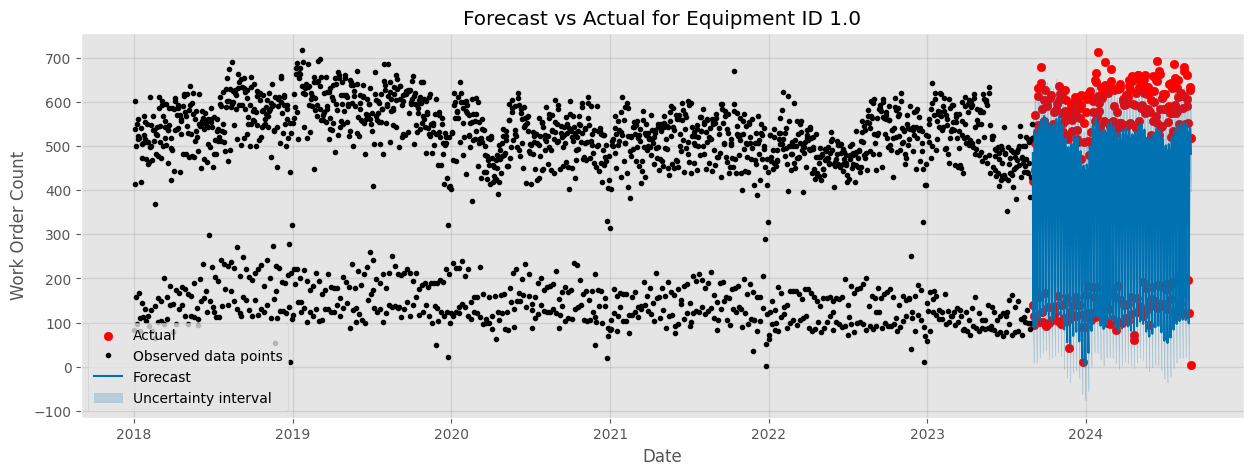

17:15:42 - cmdstanpy - INFO - Chain [1] start processing
17:15:42 - cmdstanpy - INFO - Chain [1] done processing


Equipment ID 1.0 - MAPE: 0.6238


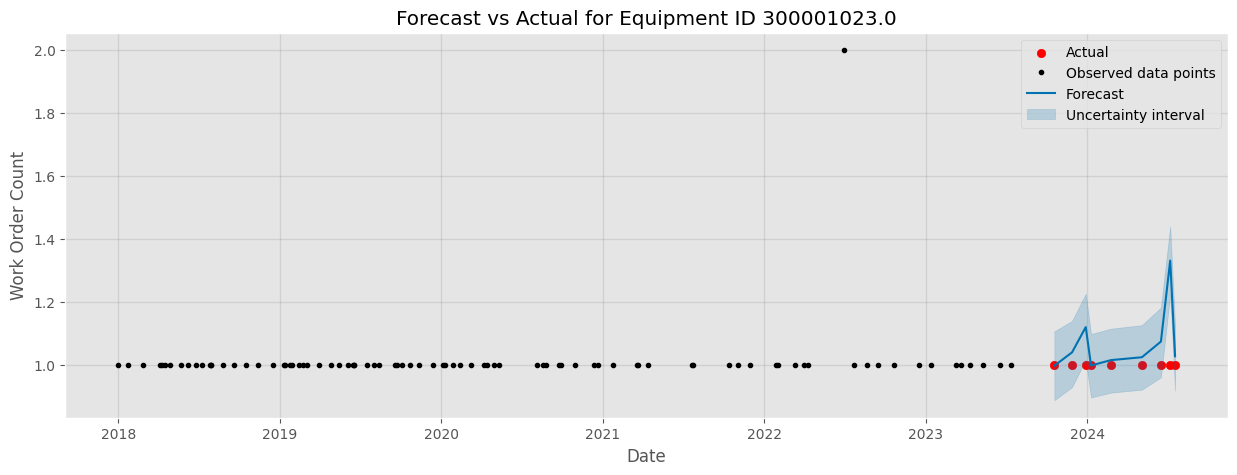

17:15:43 - cmdstanpy - INFO - Chain [1] start processing
17:15:43 - cmdstanpy - INFO - Chain [1] done processing


Equipment ID 300001023.0 - MAPE: 0.0709


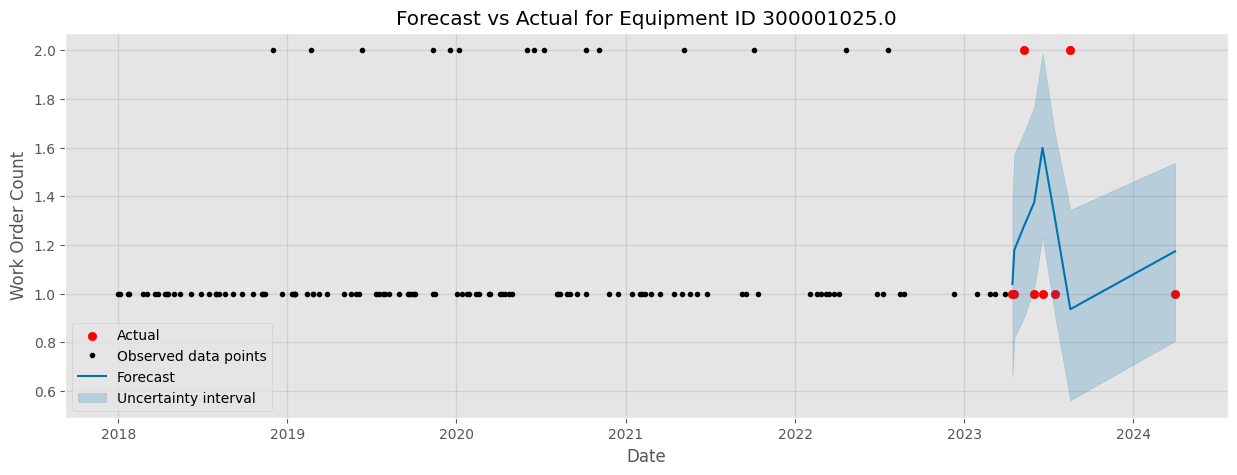

17:15:43 - cmdstanpy - INFO - Chain [1] start processing
17:15:43 - cmdstanpy - INFO - Chain [1] done processing


Equipment ID 300001025.0 - MAPE: 0.3221


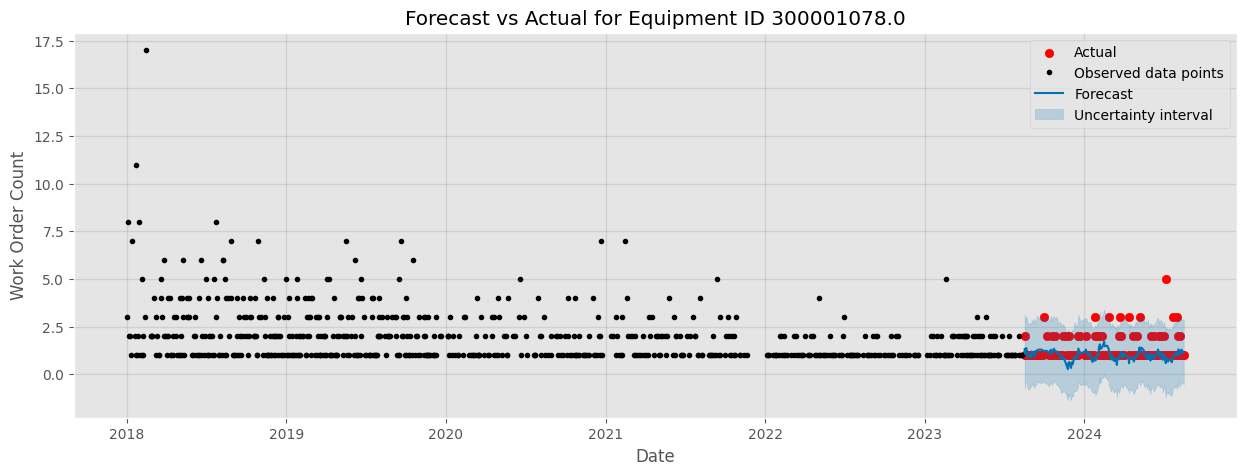

17:15:43 - cmdstanpy - INFO - Chain [1] start processing
17:15:43 - cmdstanpy - INFO - Chain [1] done processing


Equipment ID 300001078.0 - MAPE: 0.3008


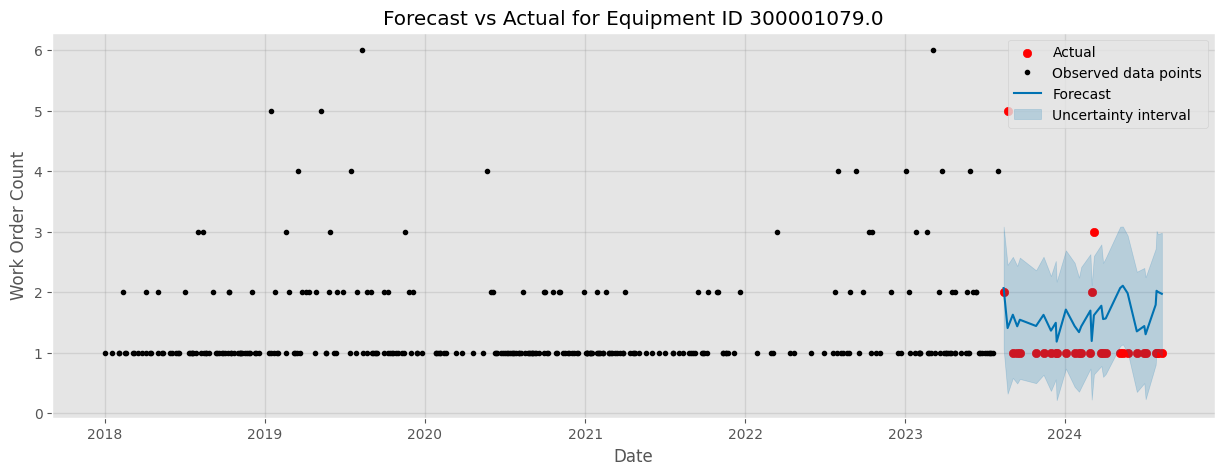

17:15:43 - cmdstanpy - INFO - Chain [1] start processing


Equipment ID 300001079.0 - MAPE: 0.5986


17:15:43 - cmdstanpy - INFO - Chain [1] done processing


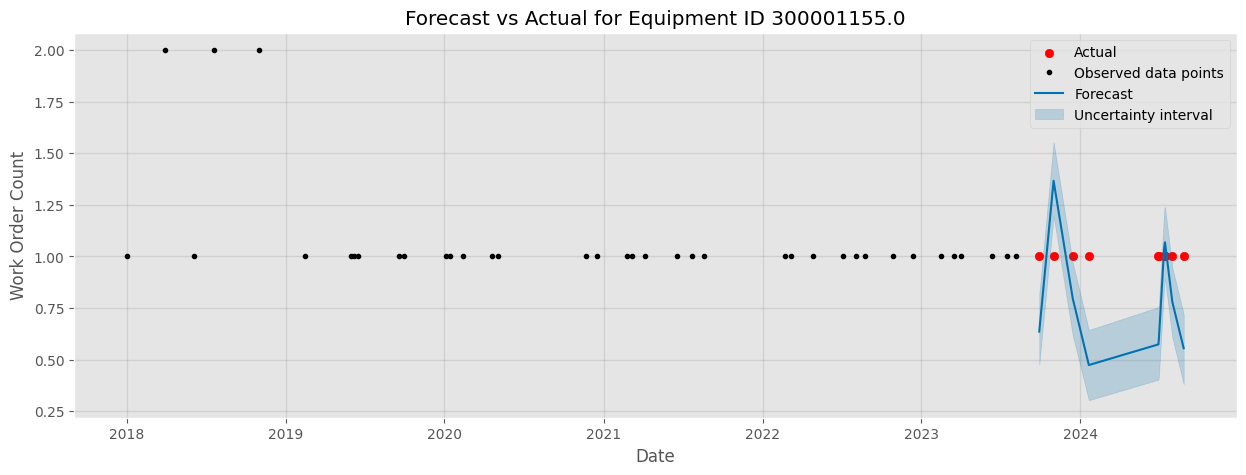

Equipment ID 300001155.0 - MAPE: 0.2833


17:15:43 - cmdstanpy - INFO - Chain [1] start processing
17:15:43 - cmdstanpy - INFO - Chain [1] done processing


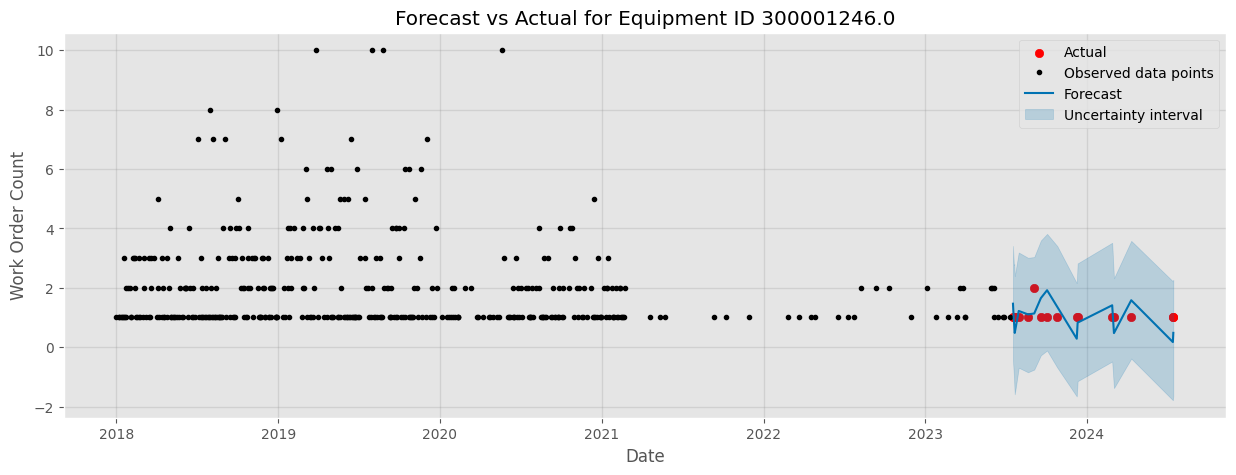

17:15:43 - cmdstanpy - INFO - Chain [1] start processing
17:15:43 - cmdstanpy - INFO - Chain [1] done processing


Equipment ID 300001246.0 - MAPE: 0.4599


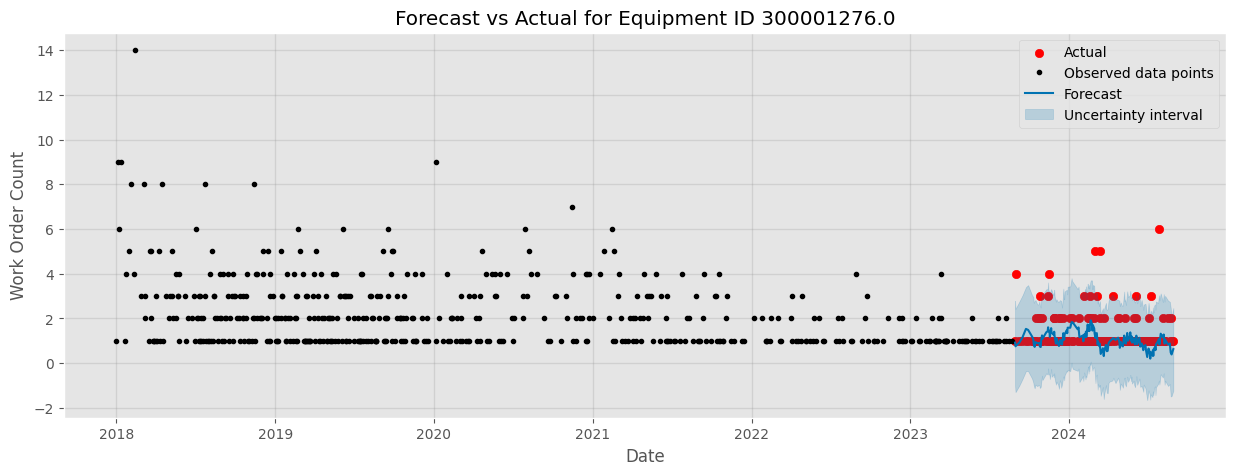

17:15:43 - cmdstanpy - INFO - Chain [1] start processing


Equipment ID 300001276.0 - MAPE: 0.3483


17:15:44 - cmdstanpy - INFO - Chain [1] done processing


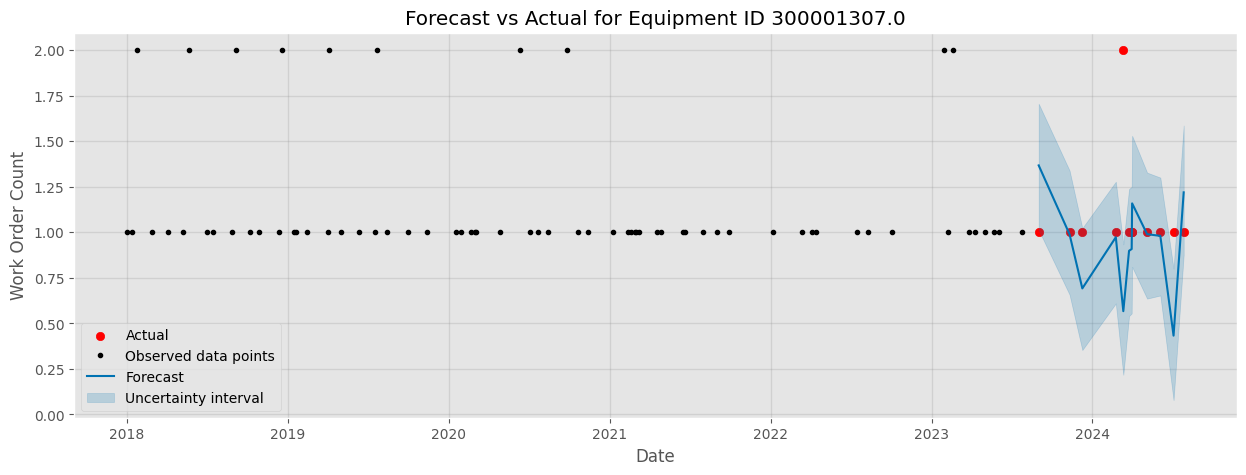

17:15:44 - cmdstanpy - INFO - Chain [1] start processing


Equipment ID 300001307.0 - MAPE: 0.2165


17:15:44 - cmdstanpy - INFO - Chain [1] done processing


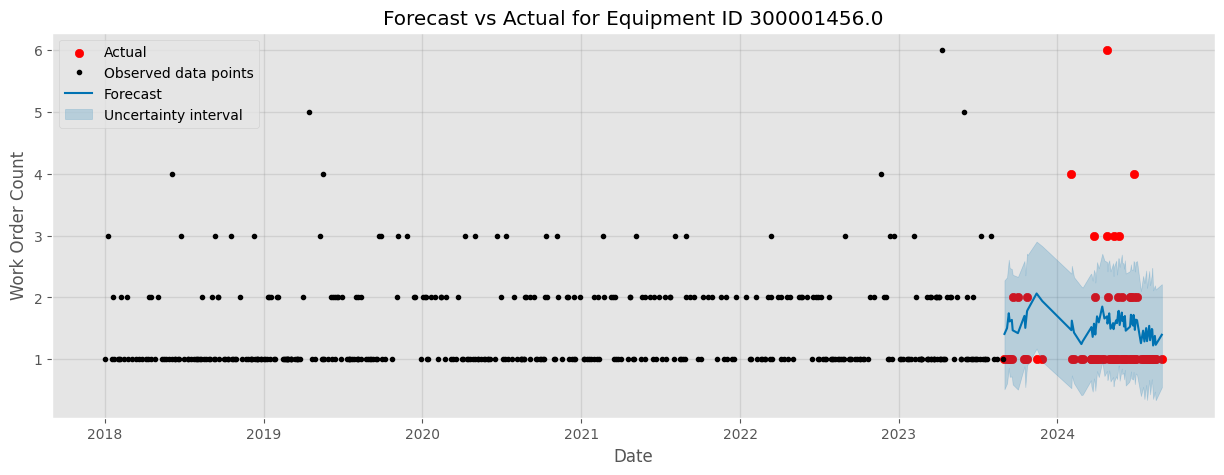

Equipment ID 300001456.0 - MAPE: 0.4873

MAPE results for all equipment:
Equipment ID 1.0: 0.6238
Equipment ID 300001023.0: 0.0709
Equipment ID 300001025.0: 0.3221
Equipment ID 300001078.0: 0.3008
Equipment ID 300001079.0: 0.5986
Equipment ID 300001155.0: 0.2833
Equipment ID 300001246.0: 0.4599
Equipment ID 300001276.0: 0.3483
Equipment ID 300001307.0: 0.2165
Equipment ID 300001456.0: 0.4873


In [328]:
for equipment_id in islice(equipment_ids, 0, 10):    
    # Filter data for the specific equipment
    equipment_data = filtered_df_roma_aggregated[filtered_df_roma_aggregated['EQUIPMENT_ID'] == equipment_id]

    split_date = equipment_data['EXECUTION_START_DATE'].max() - pd.Timedelta(days=365)

    # Prepare features and target for the entire dataset
    X, y = create_features(equipment_data.set_index('EXECUTION_START_DATE'), label='work_order_count')
    train_data_prophet = pd.concat([X, y], axis=1).reset_index() \
        .rename(columns={'EXECUTION_START_DATE': 'ds', 'work_order_count': 'y'})
    
    # Create training and testing sets
    equipment_train = train_data_prophet[train_data_prophet['ds'] <= split_date].copy()
    equipment_test = train_data_prophet[train_data_prophet['ds'] > split_date].copy()
    
    # Initialize and fit Prophet model
    model = Prophet()
    model.fit(equipment_train)
    
    # Generate forecast on the test data
    forecast = model.predict(equipment_test)
    
    # Plot the forecast with actuals
    f, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(equipment_test['ds'], equipment_test['y'], color='red', label='Actual', marker='o')
    model.plot(forecast, ax=ax)
    
    # Title and labels
    plt.title(f'Forecast vs Actual for Equipment ID {equipment_id}')
    plt.xlabel('Date')
    plt.ylabel('Work Order Count')
    plt.legend()
    plt.show()
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_true=equipment_test['y'], y_pred=forecast['yhat'])
    mape_results[equipment_id] = mape
    print(f'Equipment ID {equipment_id} - MAPE: {mape:.4f}')

# Print all MAPE results
print("\nMAPE results for all equipment:")
for equipment_id, mape in mape_results.items():
    print(f'Equipment ID {equipment_id}: {mape:.4f}')
